ResNet CNN

C:\Users\edwar\AppData\Local\Temp\ipykernel_18980\1321673434.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet.pth"))


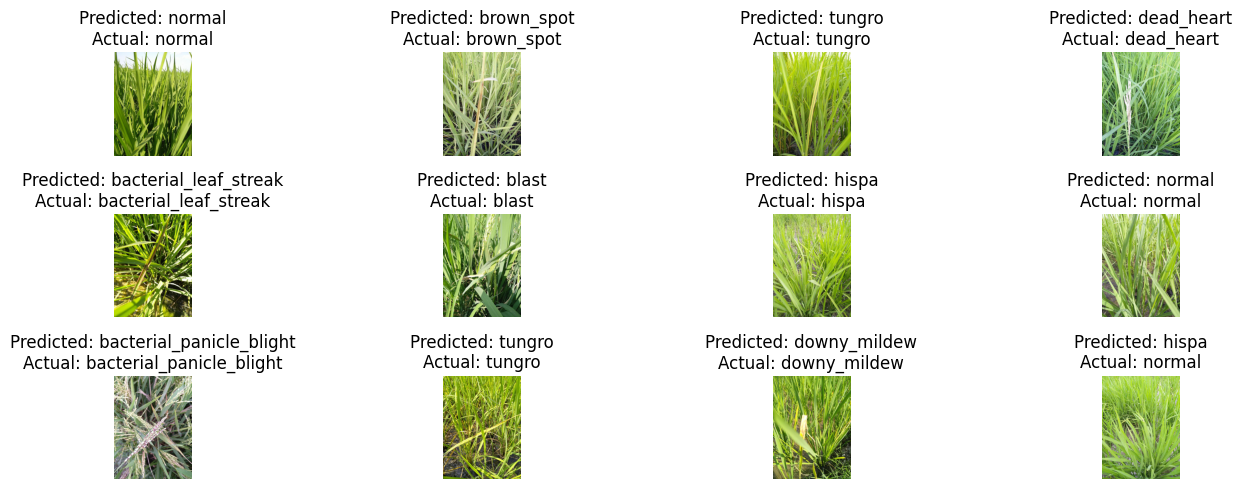

Accuracy: 91.67%
0 : 88.0
1 : 85.5
2 : 91.0
3 : 87.0
4 : 86.5
5 : 91.0
6 : 88.0
7 : 94.0
8 : 88.0
9 : 89.0
10 : 90.5
11 : 90.5
12 : 91.5
13 : 92.0
14 : 86.5
15 : 87.0
16 : 92.5
17 : 89.5
18 : 90.0
19 : 84.5
Average Accuracy over 20 runs: 89.12%


In [2]:
import os
import random
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def load_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)


def get_random_images_from_csv(csv_file, num_images=5):
    df = pd.read_csv(csv_file)
    random_rows = df.sample(n=num_images)
    images = []

    for _, row in random_rows.iterrows():
        image_path = row['image_path']
        label = row['folder_name']
        images.append((image_path, label)) 

    return images

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = ResNet(num_classes=10)
model.load_state_dict(torch.load("resnet.pth"))
model.eval() 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

test_csv = "test_images.csv"  # replace with your actual path to the CSV

num_images_to_test = 10+2  
random_images = get_random_images_from_csv(test_csv, num_images=num_images_to_test)

cols = 4
rows = (num_images_to_test // cols) + (1 if num_images_to_test % cols != 0 else 0)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
axes = axes.flatten()

correct_predictions = 0
total_predictions = 0

class_labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 
                'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

for idx, (image_path, true_label) in enumerate(random_images):
    image_tensor = load_image(image_path, transform).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class = outputs.max(1)

    predicted_label = class_labels[predicted_class.item()]
    total_predictions += 1
    if predicted_label == true_label:
        correct_predictions += 1

    image = Image.open(image_path)

    axes[idx].imshow(image)
    axes[idx].set_title(f"Predicted: {predicted_label}\nActual: {true_label}")
    axes[idx].axis('off')  # Hide the axis
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()  
plt.show()

accuracy = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy:.2f}%")


'''comment out the below part to test average accuracy by running test loop multiple times without visualization'''

num_images_to_test = 200  # Change this to control how many images to test
num_tests = 20  # Set the number of tests you want to run

accuracies = []  # List to store accuracy from each test
i =0
# Run the test multiple times
for _ in range(num_tests):
    random_images = get_random_images_from_csv(test_csv, num_images=num_images_to_test)

    correct_predictions = 0
    total_predictions = 0

    class_labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 
                    'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

    for _, (image_path, true_label) in enumerate(random_images):
        image_tensor = load_image(image_path, transform).to(device)
        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted_class = outputs.max(1)

        predicted_label = class_labels[predicted_class.item()]
        total_predictions += 1
        if predicted_label == true_label:
            correct_predictions += 1

    accuracy = (correct_predictions / total_predictions) * 100
    print(i,":",accuracy)
    i += 1
    accuracies.append(accuracy)

# Calculate the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Accuracy over {num_tests} runs: {average_accuracy:.2f}%")

ViT

C:\Users\edwar\AppData\Local\Temp\ipykernel_5532\3677986822.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet.pth"))


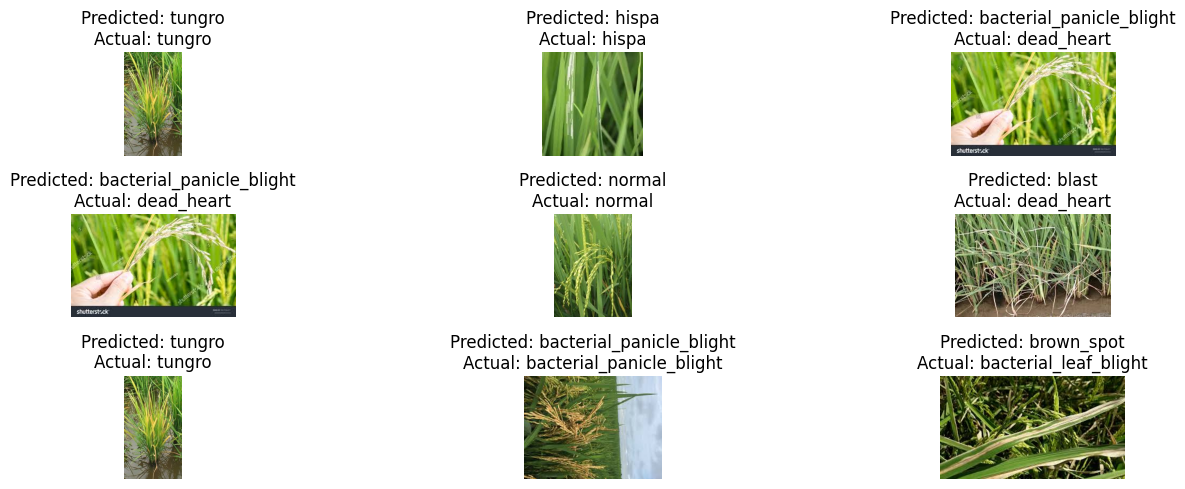

Accuracy: 55.56%


In [5]:
import os
import random
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def load_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0) 

# Function to get random images from subfolders
def get_random_images_from_subfolders(main_folder, num_images=5):
    subfolders = [f.path for f in os.scandir(main_folder) if f.is_dir()]
    images = []

    while len(images) < num_images:
        subfolder = random.choice(subfolders)
        image_files = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.png', '.jpg', '.jpeg'))]
        image_path = random.choice(image_files)
        images.append((image_path, subfolder.split(os.path.sep)[-1]))  # (image path, class label)
    
    return images

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


model = ResNet(num_classes=10)
model.load_state_dict(torch.load("resnet.pth"))
model.eval()  #  model to evaluation mode


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Path to  main folder
main_folder = "validation_images"


num_images_to_test = 9  #  change this to control how many images to test
random_images = get_random_images_from_subfolders(main_folder, num_images=num_images_to_test)

cols = 3  # adjust this based on how many images you want per row
rows = (num_images_to_test // cols) + (1 if num_images_to_test % cols != 0 else 0)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
axes = axes.flatten()

correct_predictions = 0
total_predictions = 0

class_labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 
                'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

for idx, (image_path, true_label) in enumerate(random_images):
    image_tensor = load_image(image_path, transform).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_class = outputs.max(1)

    predicted_label = class_labels[predicted_class.item()]
    total_predictions += 1
    if predicted_label == true_label:
        correct_predictions += 1

    image = Image.open(image_path)

    axes[idx].imshow(image)
    axes[idx].set_title(f"Predicted: {predicted_label}\nActual: {true_label}")
    axes[idx].axis('off')  # Hide the axis
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()  
plt.show()

accuracy = (correct_predictions / total_predictions) * 100
print(f"Accuracy: {accuracy:.2f}%")
